In [1]:
%matplotlib inline
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm_notebook
from sklearn.svm import SVR

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import pywt

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
eeglab_path = '/home/raquib/Documents/MATLAB/eeglab2019_0/functions/'
octave.addpath(eeglab_path + 'guifunc');
octave.addpath(eeglab_path + 'popfunc');
octave.addpath(eeglab_path + 'adminfunc');
octave.addpath(eeglab_path + 'sigprocfunc');
octave.addpath(eeglab_path + 'miscfunc');

In [3]:
eegs = [
    'data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
#     'data/original/sub03/exp02/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
#     'data/original/sub03/exp02/eeg/SP 110RMT r2/clean-prestimulus.set', NO CMAP
#     'data/original/sub03/exp03/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
    'data/original/sub03/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub03/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
#     'data/original/sub04/exp01/eeg/SP 110RMT r1/clean-prestimulus.set', NO CMAP
#     'data/original/sub04/exp01/eeg/SP 110RMT r2/clean-prestimulus.set', NO CMAP
#     'data/original/sub04/exp01/eeg/SP 110RMT r3/clean-prestimulus.set', NO CMAP
#     'data/original/sub05/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub06/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub08/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub08/exp03/eeg/SP 110RMT r3/clean-prestimulus.set',
    'data/original/sub12/exp02/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub13/exp01/eeg/SP 110RMT/clean-prestimulus.set',
    'data/original/sub14/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r1/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r2/clean-prestimulus.set',
    'data/original/sub15/exp01/eeg/SP 110RMT r3/clean-prestimulus.set'
]

# Read and process EEG

In [4]:
def read_eeg(path):
    eeg = octave.pop_loadset(path)
    new_trial_list = []
    for i in range(eeg.data.shape[2]):
        trial = eeg.data[:, :, i]
        time = np.linspace(-1000, -20, num=trial.shape[1])
        trial = pd.DataFrame(np.transpose(trial), columns=eeg.chanlocs.labels[0])
        trial['time'] = time
        new_trial_list.append(trial)
    return new_trial_list

def crop_trials(trial_list, duration_millis=500, sampling_rate=2048):
    new_trial_list = []
    for trial in trial_list:
        samples_to_pick = duration_millis * sampling_rate / 1000
        new_trial_list.append(trial.tail(int(samples_to_pick)))
    return new_trial_list, samples_to_pick

def filter_electrodes(trial, which='all'):
    time_column = trial['time']
    if which == 'ltm1':
        channel_names = ['FC5','FC1','C3','CP5','CP1','FC3','C5','C1','CP3']
    elif which == 'rtm1':
        channel_names = ['FC6','FC2','C4','CP6','CP2','FC4','C6','C2','CP4']
    elif which == 'central':
        channel_names = ['Fz','FCz','Cz','F1','FC1','C1','C2','FC2','F2']
    else:
        channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz']
    trial = trial[channel_names]
    trial['time'] = time_column
    return trial

In [26]:
def get_wavelet(channel, dt, im_size = [1024, 1024]):
    wa = WaveletAnalysis(channel, dt=dt)
    power_im = np.log(wa.wavelet_power)
    power_norm = power_im - power_im.mean()
    power_norm = power_norm / power_norm.ptp()
    power_norm = np.flip(scipy.ndimage.interpolation.zoom(power_im, [im_size[0]/power_im.shape[0], im_size[1]/power_im.shape[1]], order=5, prefilter=False), axis=0)
    return power_norm

def save_wavelets_of_epoch(epoch_num, epoch, path_segments):
    channel = epoch.drop('time', axis=1).mean(axis=1).values
    dt = epoch['time'].values[1] - epoch['time'].values[0]
    wavelet = get_wavelet(channel, dt)
    filename = 'wavelets/' + segments[2] + '-' + segments[3] + '-' + segments[5] + '-' + str(epoch_num) + '-all.pickle'
    with open(filename, 'wb') as f:
        pickle.dump(wavelet, f)
        
    channel = filter_electrodes(epoch, 'ltm1').drop('time', axis=1).mean(axis=1).values
    wavelet = get_wavelet(channel, dt)
    filename = 'wavelets/' + segments[2] + '-' + segments[3] + '-' + segments[5] + '-' + str(epoch_num) + '-ltm1.pickle'
    with open(filename, 'wb') as f:
        pickle.dump(wavelet, f)
        
    channel = filter_electrodes(epoch, 'rtm1').drop('time', axis=1).mean(axis=1).values
    wavelet = get_wavelet(channel, dt)
    filename = 'wavelets/' + segments[2] + '-' + segments[3] + '-' + segments[5] + '-' + str(epoch_num) + '-rtm1.pickle'
    with open(filename, 'wb') as f:
        pickle.dump(wavelet, f)
        
    channel = filter_electrodes(epoch, 'central').drop('time', axis=1).mean(axis=1).values
    wavelet = get_wavelet(channel, dt)
    filename = 'wavelets/' + segments[2] + '-' + segments[3] + '-' + segments[5] + '-' + str(epoch_num) + '-central.pickle'
    with open(filename, 'wb') as f:
        pickle.dump(wavelet, f)

AttributeError: 'list' object has no attribute 'repeat'

In [6]:
epochs = read_eeg(eegs[0])
epochs, _ = crop_trials(epochs)

pop_loadset(): loading file data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.set ...
Reading float file 'data/original/sub03/exp01/eeg/SP 110RMT r1/clean-prestimulus.fdt'...
Scaling components to RMS microvolt


In [7]:
len(epochs)

50

(-519.7706879361915, -20.0, 3.33467104602893, 1664.0008519684357)

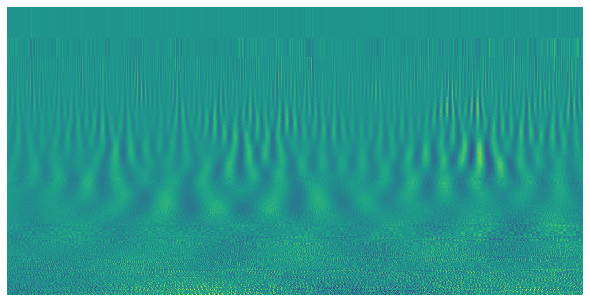

In [16]:
t = epochs[8]['time'].values
c, f = pywt.cwt(epochs[8].drop('time', axis=1).mean(axis=1).values, np.arange(1, 500), 'morl', sampling_period=0.000488281)
fig = plt.figure(figsize=(8, 4))
plt.pcolor(t, f, c)
plt.yscale('log')
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.axis('off')